<a href="https://colab.research.google.com/github/YCCS-Summer-2023-DDNMA/project/blob/145-add-michaels-notebook-to-final-code/project/final_code/TrajectV1_MB_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [ ]:
import jax
from jax import numpy as np
from jax import random as jr
from jax import vmap
from jax import ops
from matplotlib import pyplot as plt


import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from jax.scipy.stats import norm
import matplotlib.patches as patches



from dynamax.utils.plotting import plot_uncertainty_ellipses
from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.linear_gaussian_ssm import lgssm_smoother, lgssm_filter

In [ ]:
state_dim = 4
emission_dim = 2
delta = 1.0

# Create object
lgssm = LinearGaussianSSM(state_dim, emission_dim)

# Manually chosen parameters

initial_sigma = 0.1
scaling_matrix = np.array([[initial_sigma, 0., 0., 0.],
                           [0., initial_sigma, 0., 0.],
                           [0., 0., initial_sigma, 0.],
                           [0., 0., 0., initial_sigma]])

initial_mean = np.array([8.0, 10.0, 1.0, 0.0])

initial_covariance = np.eye(state_dim) * scaling_matrix



dynamic_sigma = 2.0
scaling_matrix2 = np.array([[dynamic_sigma, 0., 0., 0.],
                            [0., dynamic_sigma, 0., 0.],
                            [0., 0., dynamic_sigma, 0.],
                            [0., 0., 0., dynamic_sigma]])

dynamics_weights = np.array([[1, 0, delta, 0],
                             [0, 1, 0, delta],
                             [0, 0, 1, 0],
                             [0, 0, 0, 1]])
dynamics_covariance = np.eye(state_dim) * scaling_matrix2
emission_weights = np.array([[1.0, 0, 0, 0],
                             [0, 1.0, 0, 0]])
emission_covariance = np.eye(emission_dim) * dynamic_sigma

# lets make some innovation means for trajectory shifts
#so this specifies amount and direction in shift and test each, first two are only position shifts

innovation_mean = np.array([10.0, -20.0, 0.0, 0.0])
innovation_mean_2 = np.array([-2.0, 1.0, 0.0, 0.0])


#adding. a little acceleration (change in velocity) in following innovation means
#innovation_mean = np.array([2.0, -3.0, 0.5, -0.8])


innovation_covariance = np.eye(state_dim) * 2.0

# Initialize model with modified parameters
params, _ = lgssm.initialize(jr.PRNGKey(0),
                             initial_mean=initial_mean,
                             initial_covariance=initial_covariance,
                             dynamics_weights=dynamics_weights,
                             dynamics_covariance=dynamics_covariance,
                             emission_weights=emission_weights,
                             emission_covariance=emission_covariance)

# Generate the initial set of data with trajectory shift, test different values
num_timesteps = 15
key = jr.PRNGKey(310)
x_true, y_true = lgssm.sample(params, key, num_timesteps)

# Perform filtering for the original trajectory
#lgssm_posterior = lgssm.filter(params, y_true)


# Get filtered means and covariances for the original trajectory
#filtered_means_original = lgssm_posterior.filtered_means
#filtered_covariances_original = lgssm_posterior.filtered_covariances

#take filtered mean, the laat value and filtered covariance after filtered
#create initial covariance 2 and initial mean 2, but last values but will modify for creating new sample
#x_shifted_true and y_shifted_true
#now run filter on new sample, and modify
#3 models, LGSSM for x,y-true and get final covariance and final mean, now use that for second model
#

# Generate the shifted state trajectory
#x_shifted = x_shifted.at[0].set(x_true[-1] + innovation_mean)
x_shifted = x_true.at[0].set(x_true[-1] + innovation_mean)


# Generate the rest of the points for the shifted trajectory using the dynamics model
key = jr.PRNGKey(0)
for t in range(num_timesteps - 1):
    innovation_samples = jr.normal(key, (state_dim,))
    innovation_matrix = np.matmul(np.linalg.cholesky(innovation_covariance), innovation_samples)
    x_shifted_t = dynamics_weights @ x_shifted[t] + innovation_matrix
    x_shifted = x_shifted.at[t + 1].set(x_shifted_t)


#NO NEED TO ADD MEAN FOR EACH TIME STAMP, JUST CREATE MODEL





    # Initialize model with updated parameters for the new trajectory, for requirment #3
scaling_factor = 10
modified_initial_covariance = initial_covariance * np.array([[scaling_factor, 0., 0., 0.],
                                                            [0., scaling_factor, 0., 0.],
                                                            [0., 0., 1., 0.],
                                                            [0., 0., 0., 1.]])



# Initialize model with updated parameters for tracking
print("Last point of original trajectory (x_true[-1]):", x_true[-1])
print("Innovation mean:", innovation_mean)
params_new, _ = lgssm.initialize(jr.PRNGKey(0),
                             initial_mean=x_true[-1] + innovation_mean,
                             initial_covariance=initial_covariance,
                             dynamics_weights=dynamics_weights,
                             dynamics_covariance=dynamics_covariance,
                             emission_weights=emission_weights,
                             emission_covariance=emission_covariance)


# Generate the data with the new trajectory shift
_, y_new_shifted = lgssm.sample(params_new, key, num_timesteps)




Last point of original trajectory (x_true[-1]): [76.57246    1.8638572  5.8777046 -0.8441931]
Innovation mean: [ 10. -20.   0.   0.]


In [ ]:

import jax.numpy as jnp

def _covariance_ellipse_params(cov_matrix):
    eig_vals, eig_vecs = jnp.linalg.eigh(cov_matrix)
    angle = jnp.arctan2(eig_vecs[1, 0], eig_vecs[0, 0])
    width = jnp.sqrt(eig_vals[0])
    height = jnp.sqrt(eig_vals[1])
    return width, height, angle

def plot_lgssm_posterior(post_means, post_covs, ax=None, ellipse_kwargs=None, legend_kwargs=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    if ellipse_kwargs is None:
        ellipse_kwargs = dict(edgecolor='blue', alpha=0.2)

    if legend_kwargs is None:
        legend_kwargs = dict(loc="upper left")

    # Plot covariance at each time point.
    for t in range(len(post_means)):
        width, height, angle = _covariance_ellipse_params(post_covs[t])

        # Increase the width and height for the trajectory shift point
        if t == len(post_means) - 1:
            width *= 2.0
            height *= 2.0

        ellipse = plt.matplotlib.patches.Ellipse(
            xy=post_means[t], width=width, height=height, angle=np.degrees(angle), **ellipse_kwargs
        )
        ax.add_patch(ellipse)

    ax.plot(post_means[:, 0], post_means[:, 1], **kwargs)
    ax.scatter(post_means[:, 0], post_means[:, 1], **kwargs)

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.legend(**legend_kwargs)

# Now you can use the updated `plot_lgssm_posterior` function in your code, and it should plot the trajectory shift ellipse twice as big compared to other points.


Value of the first true state point: [8.062142 9.900726 1.       0.      ]


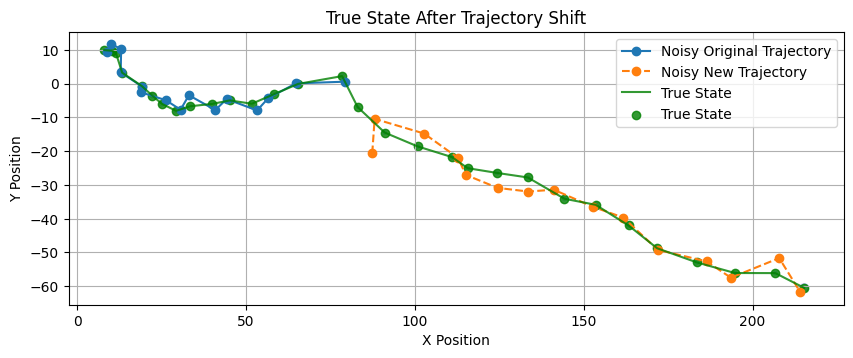

In [ ]:
#Plot to test Requriment #3 And use this for animation

###SO ISSUE LEFT IS THAT TRUE STATE STARTS AT RANDOM SPOT, SHOULD I SET IT AT FIRST

# Create the figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()


# Add noise to the observations for both original and new trajectories
noise_std_original = 1.5  # Adjustabl noise standard deviation
noise_std_new = 2  # noise standard deviation

# lets make some random noise
noise_original = jr.normal(jr.PRNGKey(0), shape=y_true.shape) * noise_std_original
noise_new = jr.normal(jr.PRNGKey(1), shape=y_new_shifted.shape) * noise_std_new

# gotta add noise to the points
noisy_y_true = y_true + noise_original
noisy_y_new_shifted = y_new_shifted + noise_new



# Plot original and post trajec
plt.plot(noisy_y_true[:, 0], noisy_y_true[:, 1], label='Noisy Original Trajectory', marker='o', linestyle='-')
plt.plot(noisy_y_new_shifted[:, 0], noisy_y_new_shifted[:, 1], label='Noisy New Trajectory', marker='o', linestyle='--')


# Perform filtering for the original trajectory
lgssm_posterior = lgssm.filter(params, y_true)

# Get filtered means and covariances for the original trajectory
filtered_means_original = lgssm_posterior.filtered_means
filtered_covariances_original = lgssm_posterior.filtered_covariances

# Perform filtering for the new trajectory using filtered_means_original[-1]
params_filter_new, _ = lgssm.initialize(jr.PRNGKey(0),
                                        initial_mean=filtered_means_original[-1],
                                        initial_covariance=filtered_covariances_original[-1] * 1,
                                        dynamics_weights=dynamics_weights,
                                        dynamics_covariance=dynamics_covariance,
                                        emission_weights=emission_weights,
                                        emission_covariance=emission_covariance)

lgssm_posterior_filtered_new = lgssm.filter(params_filter_new, y_new_shifted)

# Get filtered means and covariances for the new trajectory
filtered_means_new = lgssm_posterior_filtered_new.filtered_means
filtered_covariances_new = lgssm_posterior_filtered_new.filtered_covariances

#lets play with the uncertainty elipses :)
filtered_covariances_new *= 1.1


# Scale the covariance values for both trajectories
scaling_factor_original = 1.5  # Adjust this scaling factor as needed
scaling_factor_new = 2  # Adjust this scaling factor as needed

scaled_filtered_covariances_original = filtered_covariances_original * scaling_factor_original
scaled_filtered_covariances_new = filtered_covariances_new * scaling_factor_new



# set values for true state to make easier
first_true_state = combined_filtered_means[0]
print("Value of the first true state point:", first_true_state)
#combined_filtered_means = combined_filtered_means.at[0].set([5, 8, 0, 0])
#combined_filtered_means = combined_filtered_means.at[1].set([5, 8, 0, 0])
#combined_filtered_means = combined_filtered_means.at[2].set([5, 8, 0, 0])



# Find the index of the trajectory shift point
trajectory_shift_index = len(y_true)

# Scale the covariance value for the new trajectory at the trajectory shift point
scaling_factor_new = 2.0  # Adjust this scaling factor as needed

# Make a copy of the covariance matrix and modify only the point at the trajectory shift
modified_covariance_new = filtered_covariances_new.copy()
modified_covariance_new = modified_covariance_new.at[trajectory_shift_index].set(filtered_covariances_new[trajectory_shift_index] * scaling_factor_new)

# Combine the original and new state estimations into one curve
combined_filtered_means = np.vstack((filtered_means_original, filtered_means_new))
combined_scaled_filtered_covariances = np.vstack((scaled_filtered_covariances_original, modified_covariance_new))

# Plot the state estimation for the combined trajectory with uncertainty ellipses
plot_lgssm_posterior(combined_filtered_means, combined_scaled_filtered_covariances, ax=ax, label='True State', color='green', alpha=0.8)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('True State After Trajectory Shift')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display


#LETS MAKE SUPER SIMPLE ANIMATION FOR PRACTICE

# Create a figure and axis
fig, ax = plt.subplots()

#make the axises
ax.set_xlim(0, 7)
ax.set_ylim(0, 7)

# Initialize the line plot
line, = ax.plot([], [], 'bo-')

#  initialize the animation
def init():
    line.set_data([], [])
    return line,

# Function to update the plot at each time step
def update(frame):
    x = np.arange(1, frame + 1)
    y = x
    line.set_data(x, y)
    return line,

#  time steps (in seconds)
num_frames = 5

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True, interval=1000)

# Display the animation in my plot below (I think this function is google colab specific)
display(HTML(ani.to_jshtml()))


Value of the first true state point: [8.062142 9.900726 1.       0.      ]


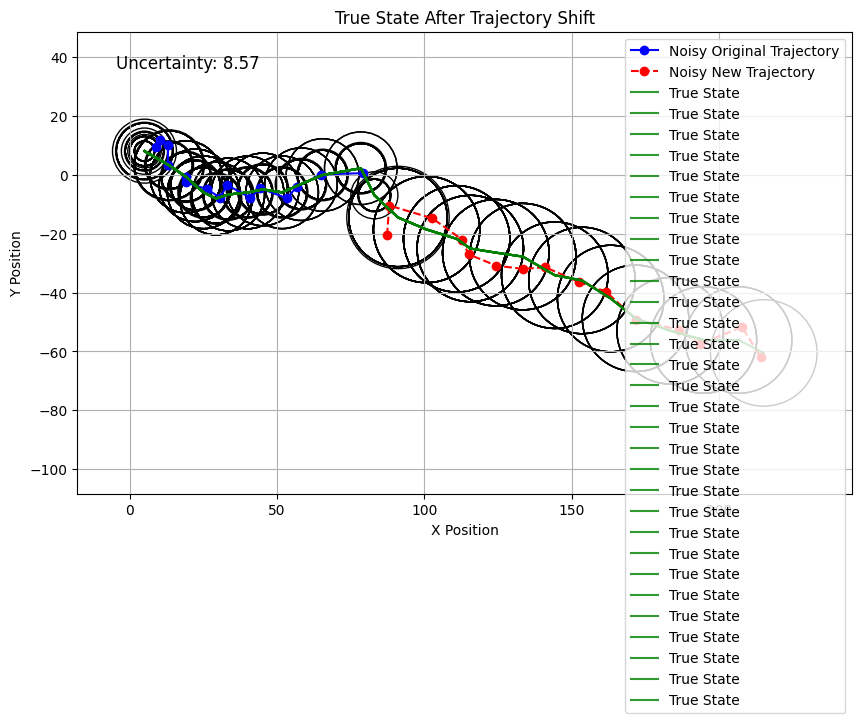

In [ ]:
#TRAJECTORY SHIFT ANIMATION


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display


#Plot to test Requriment #3 And use this for animation

###SO ISSUE LEFT IS THAT TRUE STATE STARTS AT RANDOM SPOT, SHOULD I SET IT AT FIRST




# Add noise to the observations for both original and new trajectories
noise_std_original = 1.5  # Adjustabl noise standard deviation
noise_std_new = 2  # noise standard deviation

# lets make some random noise
noise_original = jr.normal(jr.PRNGKey(0), shape=y_true.shape) * noise_std_original
noise_new = jr.normal(jr.PRNGKey(1), shape=y_new_shifted.shape) * noise_std_new

# gotta add noise to the points
noisy_y_true = y_true + noise_original
noisy_y_new_shifted = y_new_shifted + noise_new






# Perform filtering for the original trajectory
lgssm_posterior = lgssm.filter(params, y_true)

# Get filtered means and covariances for the original trajectory
filtered_means_original = lgssm_posterior.filtered_means
filtered_covariances_original = lgssm_posterior.filtered_covariances

# Perform filtering for the new trajectory using filtered_means_original[-1]
params_filter_new, _ = lgssm.initialize(jr.PRNGKey(0),
                                        initial_mean=filtered_means_original[-1],
                                        initial_covariance=filtered_covariances_original[-1] * 1,
                                        dynamics_weights=dynamics_weights,
                                        dynamics_covariance=dynamics_covariance,
                                        emission_weights=emission_weights,
                                        emission_covariance=emission_covariance)

lgssm_posterior_filtered_new = lgssm.filter(params_filter_new, y_new_shifted)

# Get filtered means and covariances for the new trajectory
filtered_means_new = lgssm_posterior_filtered_new.filtered_means
filtered_covariances_new = lgssm_posterior_filtered_new.filtered_covariances

#lets play with the uncertainty elipses :)
filtered_covariances_new *= 1.1


# Scale the covariance values for both trajectories
scaling_factor_original = 1.5  # Adjust this scaling factor as needed
scaling_factor_new = 2  # Adjust this scaling factor as needed

scaled_filtered_covariances_original = filtered_covariances_original * scaling_factor_original
scaled_filtered_covariances_new = filtered_covariances_new * scaling_factor_new


# Combine the original and new state estimations into one curve
combined_filtered_means = np.vstack((filtered_means_original, filtered_means_new))
combined_scaled_filtered_covariances = np.vstack((scaled_filtered_covariances_original, scaled_filtered_covariances_new))

# set values for true state to make it easier
first_true_state = combined_filtered_means[0]
print("Value of the first true state point:", first_true_state)

# Update the first three points in combined_filtered_means
updated_combined_filtered_means = [np.array([5, 8, 0, 0]) if i < 3 else x for i, x in enumerate(combined_filtered_means)]

# Create a new NumPy array from the updated list of arrays
combined_filtered_means = np.array(updated_combined_filtered_means)







# Rest of the code remains unchanged

# Create the figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize empty line objects for the plot
line_original, = ax.plot([], [], label='Noisy Original Trajectory', marker='o', linestyle='-', color='blue')
line_new, = ax.plot([], [], label='Noisy New Trajectory', marker='o', linestyle='--', color='red')
line_true_state, = ax.plot([], [], label='True State', color='green', alpha=0.8)

# Add text box for displaying uncertainty
text_box = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Function to initialize the plot
def init():
    line_original.set_data([], [])
    line_new.set_data([], [])
    line_true_state.set_data([], [])
    text_box.set_text('')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('True State After Trajectory Shift')
    ax.legend()
    ax.grid(True)
    # Set axis limits based on the range of x_true and y_true
    min_x, max_x = np.min(x_true[:, 0]), np.max(x_true[:, 0])
    min_y, max_y = np.min(x_true[:, 1]), np.max(x_true[:, 1])
    ax.set_xlim(min_x - 5, max_x + 5)
    ax.set_ylim(min_y - 5, max_y + 5)
    return line_original, line_new, line_true_state, text_box

# Function to update the plot for each frame of the animation
def update(frame):
    # Plot noisy original trajectory up to the current frame
    line_original.set_data(noisy_y_true[:frame, 0], noisy_y_true[:frame, 1])

    # Plot noisy new trajectory up to the current frame
    line_new.set_data(noisy_y_new_shifted[:frame, 0], noisy_y_new_shifted[:frame, 1])

    if frame > 0:
        # need to ignore initial because it is zero and causing issues
        combined_filtered_means_t = combined_filtered_means[1:frame + 1]
        combined_scaled_filtered_covariances_t = combined_scaled_filtered_covariances[1:frame + 1]
        plot_lgssm_posterior(combined_filtered_means_t, combined_scaled_filtered_covariances_t, ax=ax, label='True State', color='green', alpha=0.8)

        # Update the text box with the current uncertainty value
        current_uncertainty = np.max(combined_scaled_filtered_covariances_t)
        text_box.set_text(f'Uncertainty: {current_uncertainty:.2f}')
    else:
        text_box.set_text('')

    return line_original, line_new, line_true_state, text_box

# Number of data points (time steps)
num_frames = combined_filtered_means.shape[0]

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True, repeat=False)

# Display the animation in Google Colab
display(HTML(ani.to_jshtml()))




